### grab events from stubhub that were pulled from ticketmaster

In [1]:
import pandas as pd
import requests
import keys
import numpy as np
import datetime
import json
from tqdm import tqdm
import time

In [2]:
tm_events = pd.read_csv('tm_events.csv')

In [3]:
tm_events['date'] = pd.to_datetime(tm_events.event_date)

In [4]:
tm_events.columns

Index(['Unnamed: 0', 'event_name', 'price_min', 'price_max', 'max_tickets',
       'venue_name', 'postalCode', 'city', 'state', 'country', 'address',
       'longitude', 'latitude', 'num_markets', 'genre', 'subgenre',
       'event_date', 'is_presale', 'days_event', 'day_of_week', 'date'],
      dtype='object')

In [5]:
tm_events.date.isnull().sum()

22

In [6]:
#drop events with no date ie. 2 day fests special events
tm_events.dropna(subset=['date'], inplace=True)

In [7]:
tm_events.date.isnull().sum()

0

In [8]:
events = tm_events[['event_name','venue_name','state','date','postalCode']].copy()

### seatgeek venue translation table

In [9]:
url = 'https://api.seatgeek.com/2/venues?q='
req = requests.get(f'{url}{events.venue_name[0]}&postal_code={events.postalCode[0]}&client_id={keys.seatgeek}')

In [10]:
events.head()

,event_name,venue_name,state,date,postalCode
0,The Rocky Horror Masquerade Ball,Alabama Theatre,AL,2019-10-18 01:30:00+00:00,35203
1,AEG & Tom Joyner Present: Magic City Music Fest,BJCC Concert Hall,AL,2019-10-25 01:00:00+00:00,35203
2,Jonas Brothers: Happiness Begins Tour,Legacy Arena at The BJCC,AL,2019-11-13 01:30:00+00:00,35203
3,Eric Church: Double Down Tour,Legacy Arena at The BJCC,AL,2019-10-26 01:00:00+00:00,35203
4,Trans-Siberian Orchestra 2019 Presented By Hal...,Legacy Arena at The BJCC,AL,2019-12-11 01:30:00+00:00,35203


In [11]:
venues = events[['venue_name', 'state']].copy()

In [12]:
venues.drop_duplicates(subset=None, keep='first', inplace=True)

In [13]:
venues.reset_index(inplace=True, drop=True)

In [14]:
frame_list = []
success = []
fail = []
for i in tqdm(range(venues.shape[0])):
    venue = venues.venue_name[i].replace('-', '')
    venue = venue.replace('&', '')
    venue = venue.replace('@', '')
    venue = ('+').join(venue.strip().split()[0:3])
    url = 'https://api.seatgeek.com/2/venues?q='
    req = requests.get(f'{url}{venue}&state={venues.state[i]}&client_id={keys.seatgeek}')
    x = json.loads(req.text)
    df = pd.DataFrame(x['venues'])
    df['tm_venue'] = venues.venue_name[i]
    if len(df) == 0:
        fail.append((venues.venue_name[i], venue))
        continue
    else:
        frame_list.append(df)

100%|██████████| 1113/1113 [02:19<00:00,  7.99it/s]


In [15]:
#fix later events that failed venue search 204
len(fail)

204

In [16]:
filtered = []
for df in frame_list:
    df = df.loc[0]
    filtered.append(df)

In [17]:
df = pd.concat(frame_list)

In [18]:
sg_venues = df.copy().loc[0]

In [19]:
sg_venues.reset_index(inplace=True, drop=True)

In [20]:
sg_venues.to_csv('sg_venues.csv')

In [21]:
sg_venues = pd.read_csv('sg_venues.csv')

In [22]:
### now join csvs and query seatgeek with venue id

In [23]:
sg_venues.drop(columns=['Unnamed: 0','postal_code','address','city', 'country','postal_code',
                        'access_method','state','display_location', 'extended_address'],inplace=True)

In [24]:
tm_events.drop(columns=['Unnamed: 0'],inplace=True)

In [25]:
merged_df = pd.merge(tm_events, sg_venues, how='left',left_on='venue_name', right_on='tm_venue')

In [26]:
merged_df.columns

Index(['event_name', 'price_min', 'price_max', 'max_tickets', 'venue_name',
       'postalCode', 'city', 'state', 'country', 'address', 'longitude',
       'latitude', 'num_markets', 'genre', 'subgenre', 'event_date',
       'is_presale', 'days_event', 'day_of_week', 'date', 'links',
       'metro_code', 'timezone', 'has_upcoming_events', 'id', 'stats', 'score',
       'location', 'num_upcoming_events', 'capacity', 'slug', 'name', 'url',
       'popularity', 'name_v2', 'tm_venue'],
      dtype='object')

In [28]:
merged_df.date = merged_df.date.apply(lambda x: x.strftime('%Y-%m-%d'))

In [29]:
merged_df.dropna(subset=['id'],inplace=True)

In [30]:
merged_df.reset_index(inplace=True,drop=True)

In [31]:
merged_df.id = merged_df.id.astype('int')

In [33]:
frame_list = []
success = []
fail = []
for i in tqdm(range(merged_df.shape[0])):
    event = merged_df.event_name[i].split(':')[0]
    event = event.split('-')[0]
    event = event.split('/')[0]
    event = event.split('#')[0]
    event = event.replace('&', '')
    event = event.replace('@', '')
    url = 'https://api.seatgeek.com/2/events?q='
    req = requests.get(f'{url}{event}&venue.id={merged_df.id[i]}&client_id={keys.seatgeek}')
    x = json.loads(req.text)
    df = pd.DataFrame(x['events'])
    df['tm_event'] = merged_df.event_name[i]
    df['tm_date'] = merged_df.event_date[i]
    if len(df) == 0:
        fail.append((merged_df.event_name[i], event, merged_df.date[i]))
        continue
    else:
        frame_list.append(df)

100%|█████████▉| 2756/2757 [06:08<00:00,  8.58it/s]

KeyError: 'events'

In [34]:
df = pd.concat(frame_list, sort=True)

In [35]:
merged_df.columns

Index(['event_name', 'price_min', 'price_max', 'max_tickets', 'venue_name',
       'postalCode', 'city', 'state', 'country', 'address', 'longitude',
       'latitude', 'num_markets', 'genre', 'subgenre', 'event_date',
       'is_presale', 'days_event', 'day_of_week', 'date', 'links',
       'metro_code', 'timezone', 'has_upcoming_events', 'id', 'stats', 'score',
       'location', 'num_upcoming_events', 'capacity', 'slug', 'name', 'url',
       'popularity', 'name_v2', 'tm_venue'],
      dtype='object')

In [36]:
df.columns

Index(['access_method', 'announce_date', 'announcements', 'conditional',
       'created_at', 'date_tbd', 'datetime_local', 'datetime_tbd',
       'datetime_utc', 'description', 'enddatetime_utc', 'event_promotion',
       'general_admission', 'id', 'is_open', 'links', 'performers',
       'popularity', 'score', 'short_title', 'stats', 'status', 'taxonomies',
       'time_tbd', 'title', 'tm_date', 'tm_event', 'type', 'url', 'venue',
       'visible_until_utc'],
      dtype='object')

In [37]:
df.to_csv('tm_sg_merge.csv')

In [ ]:
df.reset_index(inplace=True)

In [21]:
df=pd.read_csv('tm_sg_merge.csv').drop(columns=['Unnamed: 0'])

In [22]:
import ast

In [23]:
df.columns

Index(['access_method', 'announce_date', 'announcements', 'conditional',
       'created_at', 'date_tbd', 'datetime_local', 'datetime_tbd',
       'datetime_utc', 'description', 'enddatetime_utc', 'event_promotion',
       'general_admission', 'id', 'is_open', 'links', 'performers',
       'popularity', 'score', 'short_title', 'stats', 'status', 'taxonomies',
       'time_tbd', 'title', 'tm_event', 'type', 'url', 'venue',
       'visible_until_utc'],
      dtype='object')

In [24]:
df.stats = df.stats.apply(lambda x: ast.literal_eval(x))
df.performers = df.performers.apply(lambda x: ast.literal_eval(x))
df.venue = df.venue.apply(lambda x: ast.literal_eval(x))

In [38]:
#unpack stats
df['listing_count']=df.stats.apply(lambda x: x['listing_count'])
df['average_price']=df.stats.apply(lambda x: x['average_price'])
df['median_price']=df.stats.apply(lambda x: x['median_price'])
df['lowest_price']=df.stats.apply(lambda x: x['lowest_price'])
df.drop(columns=['stats'], inplace =True)

In [39]:
df['headliner']= df.performers.apply(lambda x: x[0]['short_name'])

In [40]:
df.general_admission.fillna(False, inplace=True)
df['is_ga']=df.general_admission.astype('float')

In [41]:
df.rename(columns={'general_admission':'is_ga','popularity':'popularity_sg'},inplace=True)

In [42]:
df.drop(columns=['venue'],inplace=True)

In [43]:
df.columns

Index(['access_method', 'announce_date', 'announcements', 'conditional',
       'created_at', 'date_tbd', 'datetime_local', 'datetime_tbd',
       'datetime_utc', 'description', 'enddatetime_utc', 'event_promotion',
       'is_ga', 'id', 'is_open', 'links', 'performers', 'popularity_sg',
       'score', 'short_title', 'status', 'taxonomies', 'time_tbd', 'title',
       'tm_date', 'tm_event', 'type', 'url', 'visible_until_utc',
       'listing_count', 'average_price', 'median_price', 'lowest_price',
       'headliner', 'is_ga'],
      dtype='object')

In [45]:
df.drop(columns = ['index', 'announce_date','access_method','description','taxonomies','announcements', 'conditional', 'date_tbd','datetime_tbd', 'enddatetime_utc',
                   'event_promotion','type','time_tbd','links','status','is_open','datetime_utc', 'visible_until_utc','title'],inplace=True)

In [55]:
df.drop(columns= ['performers','created_at','url','score'],inplace=True)

In [56]:
df.columns

Index(['datetime_local', 'is_ga', 'id', 'popularity_sg', 'short_title',
       'tm_date', 'tm_event', 'listing_count', 'average_price', 'median_price',
       'lowest_price', 'headliner', 'is_ga'],
      dtype='object')

In [57]:
tm_events.columns

Index(['event_name', 'price_min', 'price_max', 'max_tickets', 'venue_name',
       'postalCode', 'city', 'state', 'country', 'address', 'longitude',
       'latitude', 'num_markets', 'genre', 'subgenre', 'event_date',
       'is_presale', 'days_event', 'day_of_week', 'date'],
      dtype='object')

In [58]:
tm_events.shape

(10875, 20)

In [59]:
df.shape

(6276, 13)

In [60]:
ticket_data = pd.merge(df, tm_events,how='left',left_on=['tm_event','tm_date'],
                       right_on=['event_name','event_date'])

In [67]:
ticket_data.drop_duplicates(inplace=True)

In [68]:
ticket_data.to_csv('ticket_data.csv')

In [69]:
ticket_data.shape

(6242, 33)

In [71]:
import plotly.express as px

In [72]:
ticket_data.columns

Index(['datetime_local', 'is_ga', 'id', 'popularity_sg', 'short_title',
       'tm_date', 'tm_event', 'listing_count', 'average_price', 'median_price',
       'lowest_price', 'headliner', 'is_ga', 'event_name', 'price_min',
       'price_max', 'max_tickets', 'venue_name', 'postalCode', 'city', 'state',
       'country', 'address', 'longitude', 'latitude', 'num_markets', 'genre',
       'subgenre', 'event_date', 'is_presale', 'days_event', 'day_of_week',
       'date'],
      dtype='object')

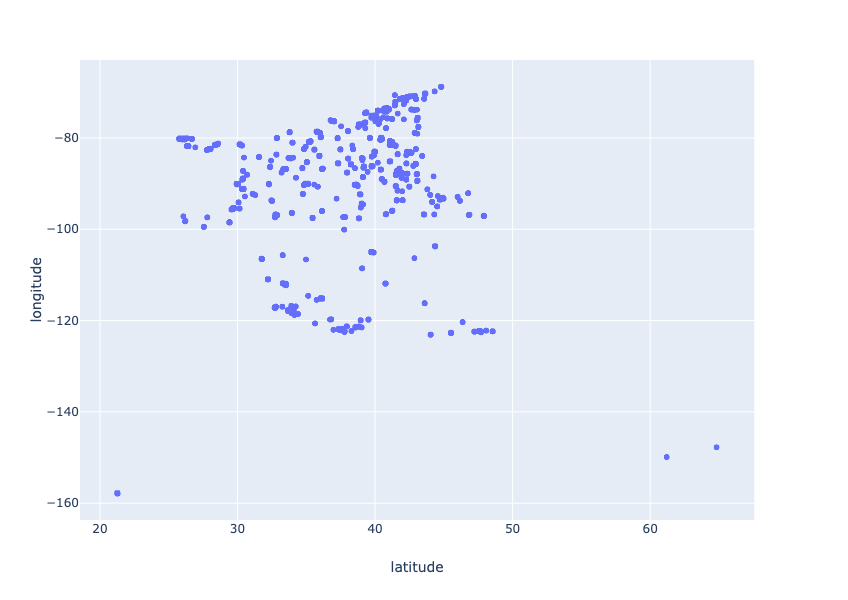

In [74]:
px.scatter_geo(ticket_data,lat='latitude',lon='longitude')